# Single task regression tutorial 

**Authorship:**
Adam Klie
***
**Description:**
In this tutorial, we use a basic workflow in EUGENe to train a single task regression model. This is a good place to start! This tutorial will walk you through the steps of training a single task model on a toy random dataset.
***

In [11]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt

# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories
eu.settings.dataset_dir = "./"
eu.settings.logging_dir = "./"
eu.settings.output_dir = "./"

# Dataloading
We first need to load our data into memory. If the dataset is a "EUGENe benchmarking dataset", it can be loaded in through the `dataset` module:
    
```python
eu.datasets.random1000()
```

If the requested dataset requires a download, it will be downloaded and loaded in automatically. Use `get_dataset_info()` to get information about the datasets available as "EUGENe benchmarking datasets".

---

You can also read from standard file formats into `SeqData` objects using `read_` functions from the `dataloading` module:

```python
eu.dl.read_csv('datasets/random1000/random1000_seqs.tsv')
```

In [3]:
sdata = eu.datasets.random1000()

In [8]:
# 
sdata 

SeqData object with = 1000 seqs
seqs = (1000,)
names = (1000,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'activity_0', 'activity_1', 'activity_2', 'activity_3', 'activity_4', 'activity_5', 'activity_6', 'activity_7', 'activity_8', 'activity_9', 'seq_len'
pos_annot: None
seqsm: None
uns: None

# Data Visualization
Data visualization is a key part of the EUGENe workflow. We can use the `plot` module to visualize aspects of our dataset like target value distributions and sequence length:

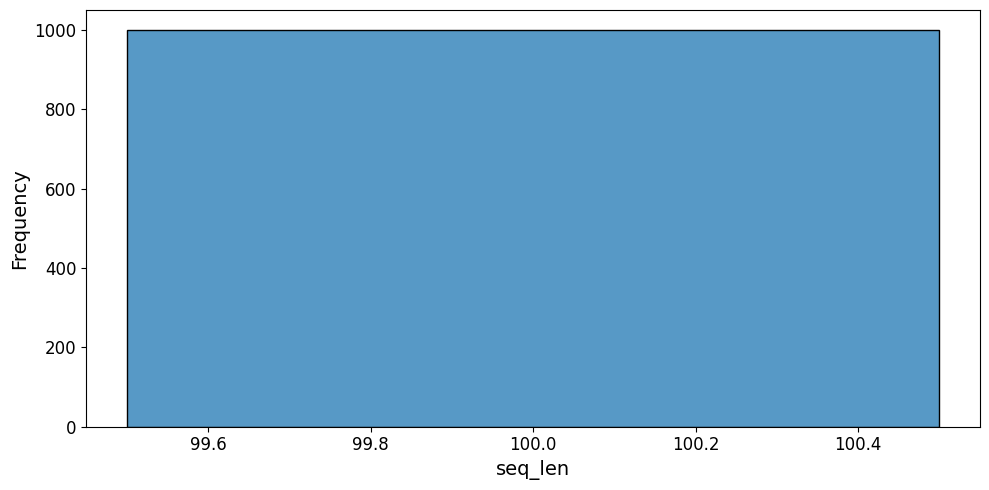

In [15]:
# This is a rather boring plot for this dataset, but many datasets will contain variable length sequences
sdata["seq_len"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)

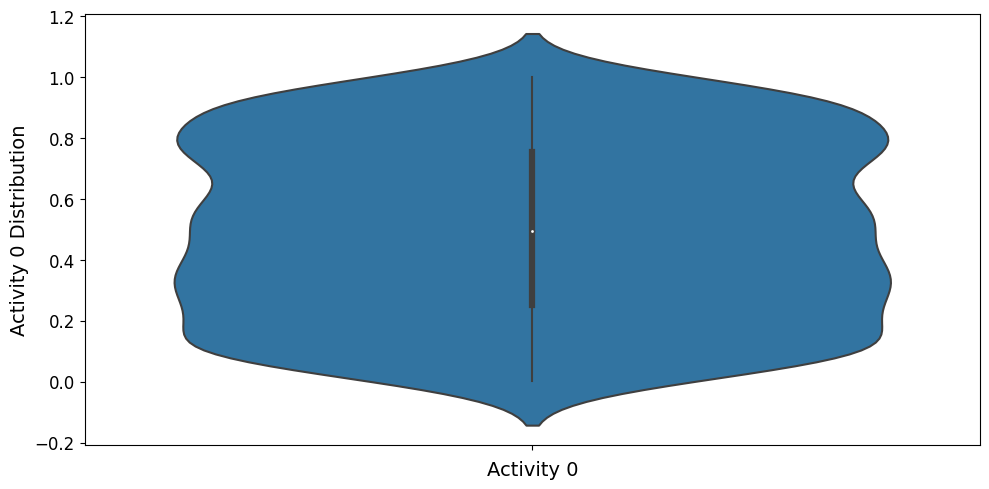

In [16]:
# We can use a violin plot ot check the distributions of our target of interest, which in this case has the key "activity_0"
eu.pl.violinplot(
    sdata,
    keys="activity_0",
    xlab="Activity 0",
    ylab="Activity 0 Distribution"
)

# Preprocessing
We can preprocess our data using the `preprocessing` module. This module includes several functions for common sequence preprocessing tasks like one-hot encoding and sequence length normalization. We can also use the `preprocessing` module to split our data into training, validation, and test sets. We encourage you to explore the `preprocess` module documentation to see the list of functions available.

Here we will use the `preprocess` function to one-hot encode our sequences and normalize their lengths to 1000:

One-hot encoding is a common way to represent sequences as a matrix of 0s and 1s, here we pass in DNA as the vocab explicitly, but this is the default

In [18]:
eu.pp.ohe_seqs_sdata(
    sdata,
    vocab="DNA"
)

One-hot encoding sequences:   0%|          | 0/1000 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 1000 ohe_seqs added


Even though its random data, lets also perform some normalization of our target label

In [21]:
eu.pp.scale_targets_sdata(
    sdata,
    target_keys="activity_0"
)

/home/vscode/.local/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


We can visualize the distribution of our targets after scaling to make sure it worked

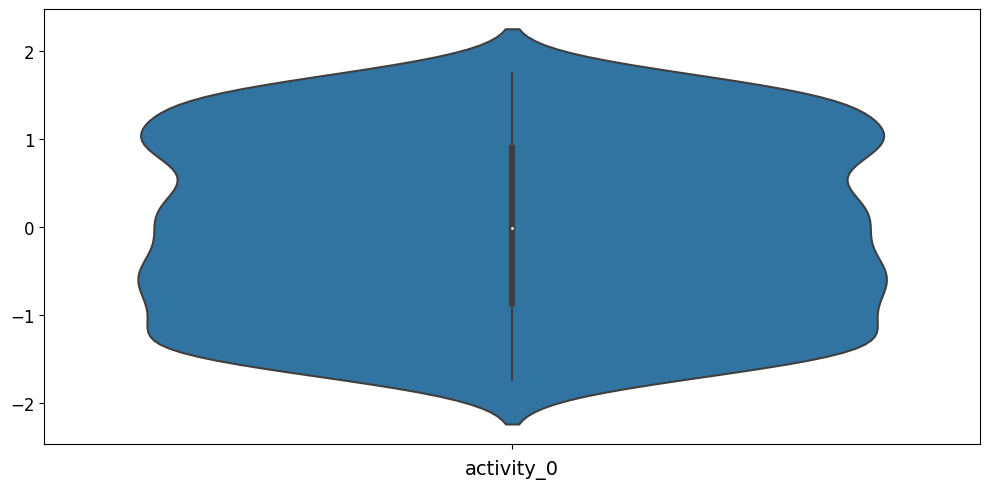

In [25]:
eu.pl.violinplot(
    sdata,
    keys="activity_0",
)

In order to train models in the classical way, we need to split our data into training, validation, and test sets. We can do this using the `split` function from the `preprocessing` module:

In [27]:
eu.pp.train_test_split_sdata(
    sdata,
    train_key="train_test",
    split=0.9
)

SeqData object modified:
    seqs_annot:
        + train_test


In [29]:
sdata_train = sdata[sdata["train_test"] == True]
sdata_test = sdata[sdata["train_test"] == False]

In [30]:
sdata_train, sdata_test

(SeqData object with = 900 seqs
 seqs = (900,)
 names = (900,)
 rev_seqs = None
 ohe_seqs = (900, 4, 100)
 ohe_rev_seqs = None
 seqs_annot: 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'activity_0', 'activity_1', 'activity_2', 'activity_3', 'activity_4', 'activity_5', 'activity_6', 'activity_7', 'activity_8', 'activity_9', 'seq_len', 'train_test'
 pos_annot: None
 seqsm: None
 uns: 'scaler',
 SeqData object with = 100 seqs
 seqs = (100,)
 names = (100,)
 rev_seqs = None
 ohe_seqs = (100, 4, 100)
 ohe_rev_seqs = None
 seqs_annot: 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'activity_0', 'activity_1', 'activity_2', 'activity_3', 'activity_4', 'activity_5', 'activity_6', 'activity_7', 'activity_8', 'activity_9', 'seq_len', 'train_test'
 pos_annot: None
 seqsm: None
 uns: 'scaler')

In [31]:
eu.pp.train_test_split_sdata(
    sdata_train,
    train_key="train_val",
    split=0.9
)

SeqData object modified:
    seqs_annot:
        + train_val


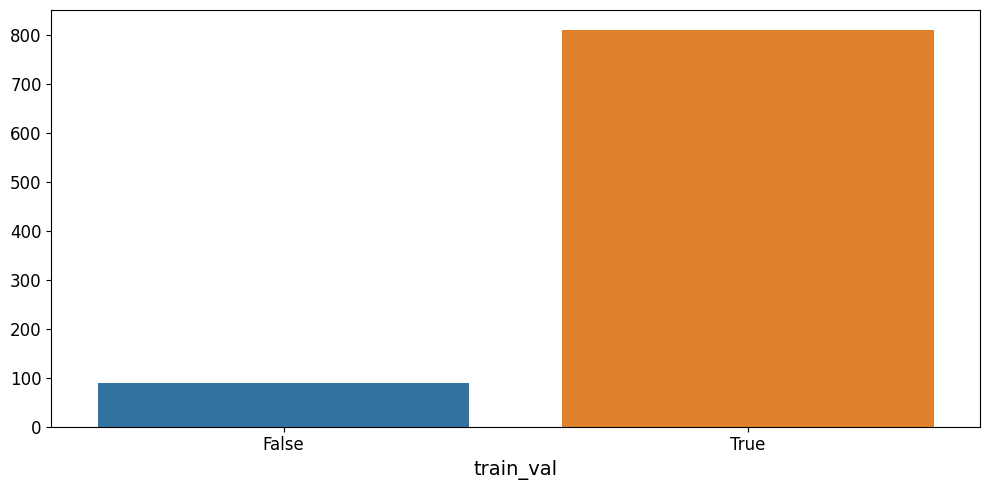

In [32]:
eu.pl.countplot(
    sdata_train,
    keys="train_val",
    orient="h"
)

# Training
Now that we have our data ready, it's time to train our model. This starts with instantiating and initializing our model. We can use the `models` module to do this:

```python
model = eu.models.DeepBind(
    input_len=100,
    output_dim=1,
    scheduler = "reduce_lr_on_plateau",
    scheduler_patience=2,
    lr=0.001
)
model.summary()
eu.models.init_weights(model)
```
We offer several options for instantiating a model architecture. Take a look at the API for more options and details.
- The `Base Model`s contain the 4 common base architectures: FCN, CNN, RNN and Hybrid. 
- The `SOTA Model`s contain 2 SOTA architectures: DeepBind and DeepSEA.
- The `Custom Models` are models that you can add to. We have  a single custom model currently implemented to serve as a template (`Jores21CNN`). Who knows? Maybe your custom model will become SOTA!

In [34]:
model = eu.models.DeepBind(
    input_len=100,
    output_dim=1,
    scheduler = "reduce_lr_on_plateau",
    scheduler_patience=2,
    lr=0.001
)

In [35]:
model.summary()

Model: DeepBind
Input length: 100
Output dimension: 1
Strand: ss
Task: regression
Aggregation: max
Loss function: mse_loss
Optimizer: adam
	Optimizer parameters: {}
Learning rate: 0.001
Scheduler: reduce_lr_on_plateau
Scheduler patience: 2


  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 1.0 K 
2 | max_pool  | MaxPool1d                 | 0     
3 | avg_pool  | AvgPool1d                 | 0     
4 | fcn       | BasicFullyConnectedModule | 1.1 K 
--------------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)

In [36]:
eu.models.init_weights(model)

With a model intantiated and initialized, we are set up to train our model. We can do this through the `train` module:

```python
eu.train.fit(
    model=model, 
    sdata=sdata, 
    gpus=1, 
    target="target",
    train_key="train",
    epochs=50,
    version=f"v1"
)
```

We can see how well our models trained by plotting a training summary:

```python
eu.train.pl_training_summary(model_leaf, version=f"v1")
```

In [40]:
eu.train.fit(
    model=model, 
    sdata=sdata_train, 
    target_keys="activity_0",
    train_key="train_val",
    epochs=50,
    version=f"v1"
)

Global seed set to 13
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2022-09-18 22:16:27.581078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 22:16:27.781382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


2022-09-18 22:16:27.781415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-18 22:16:27.809758: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-18 22:16:28.849493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-18 22:16:28.849642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-09-18 22:16:28.849652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU

Validation sanity check: 0it [00:00, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 13
/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: U

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluation
After the model's been trained, we can evaluate our performance on our training data and our held-out test data. This is done through the `plotting` module.
It is often best to use the model that achieved the lowest loss on the validation data for evaluation. We can load this model in from the log directory:

In [41]:
eu.evaluate.predictions(
    model=model,
    sdata=sdata_test,
    target_keys="activity_0",
    version="v1"
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize.


/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + activity_0_predictions


In [ ]:
# TODO: If you have a test set, see how you did on that

# Interpretation
Potentially the most important step in the EUGENe workflow is the interpretation of the model's predictions. This is done through the `interpret` module. All the functions in this module act on either `SeqData` and Models or just Models. Results from these calls can be visualized using the `plotting` module.
---
There are many options for interpreting the model's predictions, and we will again point users to the API for all the options and their arguments. We list examples for a few common ones below.


```python
eu.interpret.generate_pfms(
    best_model_leaf, 
    sdata_leaf_test
)
```

## Feature attribution
We can calculate the contribution of each nucleotide to the model's predictions for a sequence by using the `interpret` module's `feature_attribution` function. We currently implement several different methods for this, includeing `DeepLift, ISM, InputXGradient and DeepSHAP`.
```python
eu.interpret.feature_attribution(
    best_model,
    sdata_test,
    saliency_method="DeepLift",
    device= "cuda" if eu.settings.gpus > 0 else "cpu"
)
```

In [6]:
# TODO: Run feature attribution on your model

## Filter Visualization 
We can get an idea for what each filter of first convoulional layer of the model is seeing by using the `interpret` module's `generate_pfms` function. This creates a position frequency matrix for each filter in the model using sequences that highly activate that filter (can be defined in multiple ways). We often times pass the the test sequences through the model, but you can theoretically pass any sequences you want.
```python
eu.interpret.generate_pfms(
    best_model, 
    sdata_test
)
```

In [7]:
# TODO: Run filter visualization on your model

## Other intepretation methods
We currently implement a few other methods for interpreting the model's predictions. These include:
- Dimensionality Reduction on your importance scores: e.g. `eu.interpret.pca`
- ...
We are looking to add more! If you are interested in contributing...

In [ ]:
# TODO: Perform other intepretation methods on your trained model

# Wrapping up
EUGENe is very much meant to be a community project. It represents a collection of data, models, and techniques meant for analyzing sequence data with deep learning. We are looking for contributions in almost every aspect of EUGENe. We are particularly interested in:

- New model additions through the `models` module
- New dataset additions through the `datasets` module
- New preprocessing techniques through the `preprocessing` module
- New visualization techniques through the `plotting` module
- New interpretation techniques through the `interpret` module
- New methods for training models in the `train` module

Please do not hesitate to contact us if you have any questions or suggestions.

---